In [1]:
import numpy as np
from pylab import *

%matplotlib notebook

In [2]:
# trace is a list of (width, offset), one for each channel
nchan = 8
trace1 = [(0, np.array([1])) for w in range(nchan)]
trace2 = [(0, np.array([1])) for w in range(nchan//2)] + [(0, np.array([1,1])) for w in range(nchan//2)]
trace3 = [(1, np.array([1])) for w in range(nchan)]
trace4 = [(1, np.array([1])) for w in range(nchan//2)] + [(1, np.array([1,2,1])) for w in range(nchan//2)]
trace5 = [(0, np.array([1,1])) for w in range(nchan)]
trace6 = [(0, np.ones(w+1)) for w in range(nchan)]


traces = [trace1, trace2, trace3, trace4]
traces = [trace2, trace6]

In [3]:
trace2

[(0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1, 1])),
 (0, array([1, 1])),
 (0, array([1, 1])),
 (0, array([1, 1]))]

In [4]:
def trace2image(trace):
    '''
    Produces and image given a trace
    Trace is a list of (offset, kernel) tuples - length nchannels
    offset if positive for backwards in time.
    Offset for channel i is between channel i and channel i+1
    The value for time t is the convolution of the previous N samples (N=size of kernel)
    '''
    nc = len(trace)
    kernels = [t[1] for t in trace]
    offsets = [t[0] for t in trace]
    last_off = offsets[-1]
    total_offset = sum(offsets)
    kernel_lengths = map(len, kernels)
    largest_kernel = max(kernel_lengths)
    # TODO: Fix nt - this isn't right. We need to loop through the trace and work out what hte smallest start index would be
    curr_start = 0
    smallest_start = 0
    for offset, kernel in trace:
        endidx = curr_start
        startidx = endidx - len(kernel)
        if startidx < smallest_start:
            smallest_start = startidx
        
        curr_start -= offset    
    
    nt = -smallest_start
    #print('trace2image nc=', nc, 'total_offset', total_offset, 'largest_kernel', largest_kernel, 'nt=', nt)
    mask = np.zeros((nc,nt))
    curr_start = nt # cumulative offset - right hand side of kernel
    for ichan, (offset, kernel) in enumerate(trace):       
        endidx = curr_start
        startidx = endidx - len(kernel)
        #print(ichan, offset, kernel, curr_start, startidx, endidx)
        mask[ichan, startidx:endidx] = kernel
        curr_start -= offset
        
   #assert coffset - len(kernel) == 0, f'Coffset should be 0 it was {coffset}'
        
        
    return mask
    

In [5]:
trace2image(trace6)

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.]])

<IPython.core.display.Javascript object>


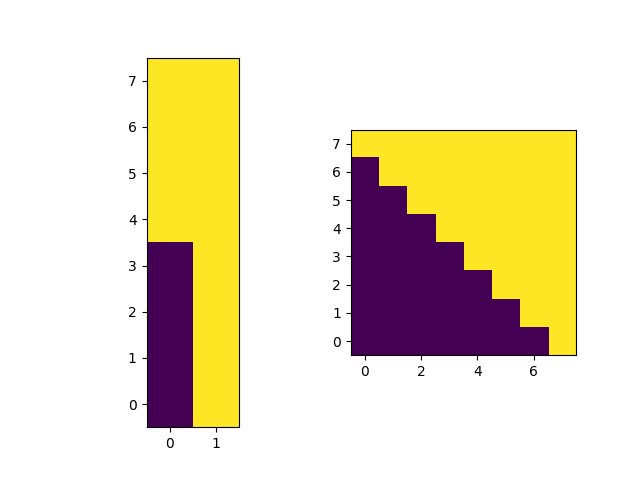

[(0, array([1])), (0, array([1])), (0, array([1])), (0, array([1])), (0, array([1, 1])), (0, array([1, 1])), (0, array([1, 1])), (0, array([1, 1]))] (8, 2)
[(0, array([1.])), (0, array([1., 1.])), (0, array([1., 1., 1.])), (0, array([1., 1., 1., 1.])), (0, array([1., 1., 1., 1., 1.])), (0, array([1., 1., 1., 1., 1., 1.])), (0, array([1., 1., 1., 1., 1., 1., 1.])), (0, array([1., 1., 1., 1., 1., 1., 1., 1.]))] (8, 8)


In [6]:
fig, ax = subplots(1,len(traces), squeeze=False)
for myax, t in zip(ax.flatten(), traces):
    img = trace2image(t)
    print(t, img.shape)
    myax.imshow(img, origin='lower')


In [7]:
from collections import namedtuple
Product = namedtuple('Product', ['pid_upper','pid_lower','offset', 'desc'])

class EndProduct:
    def __init__(self, trace, desc):
        self.desc = desc
        self.top_offset, self.kernel = trace
    
    @property
    def offset(self):
        return self.top_offset
        
    def __str__(self):
        s = f'EndProduct kernel={self.kernel}'
        return s
    
    def __eq__(self, other):
        '''
        Need this otherwise we keep adding the same kernel at the bottom level
        '''    
        iseq = np.array_equal(self.kernel, other.kernel)
        return iseq
    
    __repr__ = __str__

    

class EsamTree:
    def __init__(self, nchan, ichan):
        self._products = [] # list containing Products
        self.nchan = nchan
        self.ichan = ichan
        assert self.nchan == 1 or self.nchan % 2 == 0
        
        if nchan == 1:
            self.upper = None
            self.lower = None
        else:
            # normally we'd do FdmtDescriptor here, butif we make a new __class_ if we have a subclass
            # then it'll create the right class
            self.upper = self.__class__(nchan // 2, 2*ichan+1)
            self.lower = self.__class__(nchan // 2, 2*ichan)
        
    @property
    def ndm(self):
        return len(self._products)
    
    @property
    def nprod(self):
        return self.ndm
    
    @property
    def total_products(self):
        '''
        Returns total number of products in hierarchy
        '''
        if self.nchan == 1:
            return self.nprod
        else:
            return self.upper.total_products + self.lower.total_products + self.nprod
        
    def descriptor_tree(self, tree=None, level=0):
        '''
        Returns a list. Each element contains another list. That list contains all descriptors for that iteration
        '''
        if tree is None:
            tree = []
        if self.ichan == 0:
            tree.append([])
            
        tree[level].append(self)
        if self.nchan != 1:
            self.lower.descriptor_tree(tree, level+1)
            self.upper.descriptor_tree(tree, level+1)
        
        return tree              
    
    def get_all_pids(self, all_pids):
        list_idx = int(np.log2(self.nchan))
        if self.nchan == 1:
            all_pids[list_idx].extend(self._products)
        else:
            all_pids[list_idx].extend(self._products)
            self.upper.get_all_pids(all_pids)
            self.lower.get_all_pids(all_pids)
    
    def get_trace_pid(self, trace, doprint=False) -> int:
        '''
        Returns the product ID for the given trace
        trace:list of nchan values. Each value is tuple(width, offset)'
        '''
        assert len(trace) == self.nchan, f'Unexpedcted trace length in {self}. Was {len(trace)} expected {self.nchan}'
        
        n2 = self.nchan // 2
        if self.nchan == 1:
            prod = EndProduct(trace[0], self)
            total_offset = prod.offset
        else:
            pid_lower, offset_lower = self.lower.get_trace_pid(trace[:n2])
            pid_upper, offset_upper = self.upper.get_trace_pid(trace[n2:])
            prod = Product(pid_upper, pid_lower, offset_lower, self)
            total_offset = offset_lower + offset_upper
        
        added = False
        if prod not in self._products:
            self._products.append(prod)
            added = True
            
        pid = self._products.index(prod)
        if doprint:
            print(f'{self} of trace {trace}={prod}=PID{pid} added?={added} total_offset={total_offset}')  
        return pid, total_offset
           
    def __str__(self):
        s = f'Nchan={self.nchan} chan={self.ichan} ndm={self.ndm}'
        return s
    
    def __call__(self, din, doprint=False):
        assert din.shape[0] == self.nchan
        nt = din.shape[1]
        dout = np.zeros((self.nprod, nt)) # NT here is a bit tricky
        
        if self.nchan == 1:
            assert din.shape[0] == 1, f'Expected 1 channel. Got {din.shape}'
            for iprod, prod in enumerate(self._products):
                kernel = prod.kernel
                
                # this worked, but it would be good to spell it out more completely
                istart = 0
                dout[iprod, :] = np.convolve(din[0], kernel, mode='full')[istart:nt+istart]
                # n = len(kernel)                
                # TODO: Implement history
                # This is equivalent, but it's horrendously slow
                #for endidx in range(n, nt):                    
                #    # only look backwards in time
                #    startidx = endidx - n
                #    assert startidx >= 0
                #    dout[iprod, endidx] = np.dot(din[0, startidx:endidx], kernel)

        else:
            nf2 = self.nchan // 2 
            lower = self.lower(din[:nf2,...], doprint)
            upper = self.upper(din[nf2:,...], doprint)
            for iprod, prod in enumerate(self._products):

                off = prod.offset          
                

                if doprint:
                    print(f'{self.ichan}/{self.nchan} setup {off}', 'lower', lower[prod.pid_lower,:].shape, 'upper', upper[prod.pid_upper,:].shape, 'slice', slice(0, nt-off))
                    
                                    
                dout[iprod, :] = lower[prod.pid_lower, :]
                if off < nt: # if hte offset is larger than NT then ... I don't know what to do?!
                    dout[iprod, off:] += upper[prod.pid_upper, :nt-off]
                
                
                
                if doprint:
                    print(f'{self.ichan}/{self.nchan} upper {off}', upper[prod.pid_upper,:])
                    print(f'{self.ichan}/{self.nchan} lower {off}', lower[prod.pid_lower,:])
                    print(f'{self.ichan}/{self.nchan} dout  {off}', dout[iprod,:])
                
                
            
        return dout                        
    
    __repr__ = __str__
    
    
d = EsamTree(nchan,0)
d

Nchan=8 chan=0 ndm=0

In [8]:
[d.get_trace_pid(t) for t in traces]

[(0, 0), (1, 0)]

In [9]:
d.total_products

29

<IPython.core.display.Javascript object>


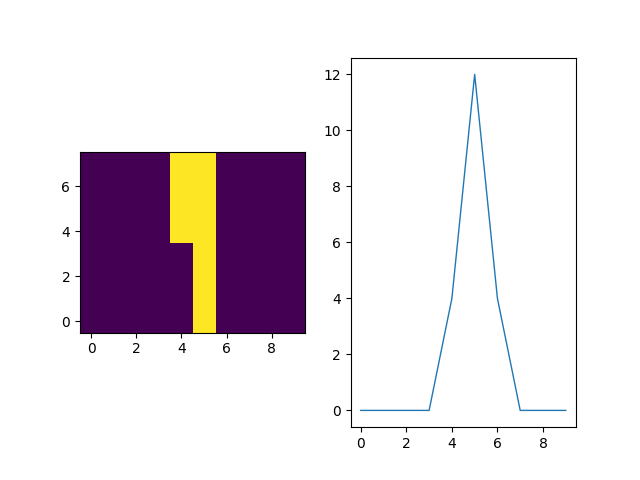

0/2 setup 0 lower (10,) upper (10,) slice slice(0, 10, None)
0/2 upper 0 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0/2 lower 0 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0/2 dout  0 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]
0/2 setup 0 lower (10,) upper (10,) slice slice(0, 10, None)
0/2 upper 0 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
0/2 lower 0 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0/2 dout  0 [0. 0. 0. 0. 0. 2. 1. 0. 0. 0.]
1/2 setup 0 lower (10,) upper (10,) slice slice(0, 10, None)
1/2 upper 0 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
1/2 lower 0 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
1/2 dout  0 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]
1/2 setup 0 lower (10,) upper (10,) slice slice(0, 10, None)
1/2 upper 0 [0. 0. 0. 0. 0. 1. 1. 1. 1. 0.]
1/2 lower 0 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0.]
1/2 dout  0 [0. 0. 0. 0. 0. 2. 2. 2. 1. 0.]
0/4 setup 0 lower (10,) upper (10,) slice slice(0, 10, None)
0/4 upper 0 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]
0/4 lower 0 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]
0/4 dout  0 [0. 0. 0. 0. 0. 4. 0. 0. 0. 0.]
0/4 setup 0 lower (10,) upper (10,)

In [10]:
fig, ax = subplots(1,2)
img3 = trace2image(trace2)
pad = np.zeros((nchan,4))
img3 = np.hstack([pad,img3,pad])
dout3 = d(img3, doprint=True)
ax[0].imshow(img3, origin='lower')
ax[1].plot(dout3[0,])
print(img3.sum(), dout3.max())

In [11]:
din = np.ones((d.nchan, 16))
din[:] = 0
din[:,8] = 1
dout = d(din, doprint=True)
print(dout.shape)
dout

0/2 setup 0 lower (16,) upper (16,) slice slice(0, 16, None)
0/2 upper 0 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
0/2 lower 0 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
0/2 dout  0 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
0/2 setup 0 lower (16,) upper (16,) slice slice(0, 16, None)
0/2 upper 0 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
0/2 lower 0 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
0/2 dout  0 [0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 0. 0. 0. 0. 0. 0.]
1/2 setup 0 lower (16,) upper (16,) slice slice(0, 16, None)
1/2 upper 0 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1/2 lower 0 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1/2 dout  0 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
1/2 setup 0 lower (16,) upper (16,) slice slice(0, 16, None)
1/2 upper 0 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
1/2 lower 0 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
1/2 dout  0 [0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 1. 0. 0. 0. 0.]
0/4 setup 0 

array([[0., 0., 0., 0., 0., 0., 0., 0., 8., 4., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 8., 7., 6., 5., 4., 3., 2., 1.]])

<IPython.core.display.Javascript object>


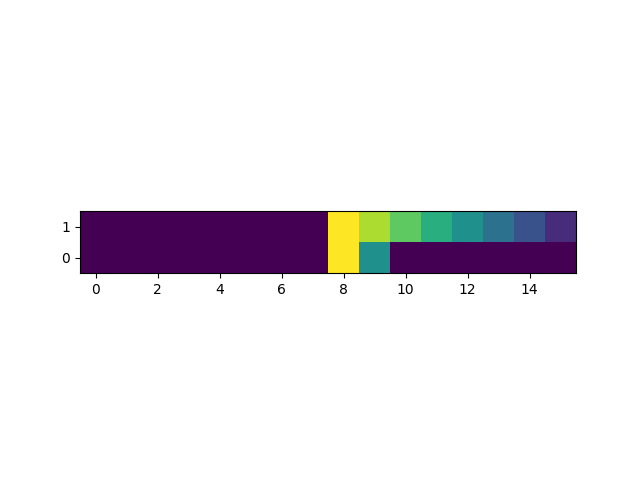

In [12]:
figure()
imshow(dout, origin='lower')

In [13]:
# unit tests
e1 = EndProduct((0,np.array([1,2,3])), None)
e2 = EndProduct((0,np.array([1,2,5])), None)
e3 = EndProduct((0,np.array([1])), None)

#e1 == e2
assert e1 in [e2,EndProduct((0,np.array([1,2,3])), None)] 
assert e3 not in [e1,e2] 
assert e3 not in [EndProduct((0, np.array([1,1])), None)]

In [14]:
mtree = d.descriptor_tree()
print('tree depth', len(mtree))
for itree, t in enumerate(mtree):
    print('tree level', itree, 'nnodes=', len(t), t)

tree depth 4
tree level 0 nnodes= 1 [Nchan=8 chan=0 ndm=2]
tree level 1 nnodes= 2 [Nchan=4 chan=0 ndm=2, Nchan=4 chan=1 ndm=2]
tree level 2 nnodes= 4 [Nchan=2 chan=0 ndm=2, Nchan=2 chan=1 ndm=2, Nchan=2 chan=2 ndm=2, Nchan=2 chan=3 ndm=2]
tree level 3 nnodes= 8 [Nchan=1 chan=0 ndm=1, Nchan=1 chan=1 ndm=2, Nchan=1 chan=2 ndm=2, Nchan=1 chan=3 ndm=2, Nchan=1 chan=4 ndm=2, Nchan=1 chan=5 ndm=2, Nchan=1 chan=6 ndm=2, Nchan=1 chan=7 ndm=2]


<IPython.core.display.Javascript object>


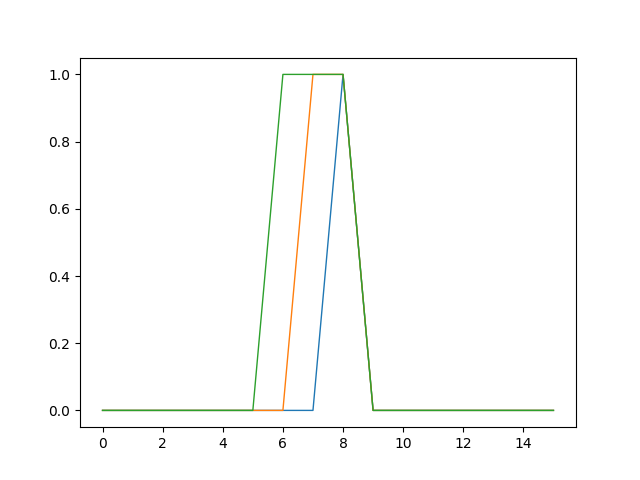

In [15]:
figure()
t = np.zeros(16)
t[8] = 1
mode = 'full'
plot(np.convolve(t, np.array([1]), mode))
plot(np.convolve(t, np.array([1,1]), mode)[1:])
plot(np.convolve(t, np.array([1,1,1]), mode)[2:])

In [16]:
d.lower.nchan

4

In [17]:
d.lower.lower.nchan

2

In [18]:
d.upper.upper.upper.ichan

7

In [19]:
len(trace1)

8

In [20]:
d.get_trace_pid(trace1)

(2, 0)

In [21]:
d.get_trace_pid(trace1)

(2, 0)

In [22]:
d._products

[Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=8 chan=0 ndm=3),
 Product(pid_upper=1, pid_lower=1, offset=0, desc=Nchan=8 chan=0 ndm=3),
 Product(pid_upper=2, pid_lower=0, offset=0, desc=Nchan=8 chan=0 ndm=3)]

In [23]:
d.total_products

37

In [24]:
trace1

[(0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1]))]

In [25]:
trace2

[(0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1])),
 (0, array([1, 1])),
 (0, array([1, 1])),
 (0, array([1, 1])),
 (0, array([1, 1]))]

In [26]:
d.get_trace_pid(trace2)

(0, 0)

In [27]:
d.total_products

37

In [28]:
trace4

[(1, array([1])),
 (1, array([1])),
 (1, array([1])),
 (1, array([1])),
 (1, array([1, 2, 1])),
 (1, array([1, 2, 1])),
 (1, array([1, 2, 1])),
 (1, array([1, 2, 1]))]

In [29]:
d.get_trace_pid(trace3)

(3, 8)

In [30]:
d.get_trace_pid(trace4)

(4, 8)

In [31]:
d._products

[Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=8 chan=0 ndm=5),
 Product(pid_upper=1, pid_lower=1, offset=0, desc=Nchan=8 chan=0 ndm=5),
 Product(pid_upper=2, pid_lower=0, offset=0, desc=Nchan=8 chan=0 ndm=5),
 Product(pid_upper=3, pid_lower=2, offset=4, desc=Nchan=8 chan=0 ndm=5),
 Product(pid_upper=4, pid_lower=2, offset=4, desc=Nchan=8 chan=0 ndm=5)]

In [32]:
d.total_products

52

In [33]:
all_pids = [[] for i in range(int(np.log2(nchan))+1)]
d.get_all_pids(all_pids)
all_pids[1]

[Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=3 ndm=5),
 Product(pid_upper=1, pid_lower=1, offset=0, desc=Nchan=2 chan=3 ndm=5),
 Product(pid_upper=2, pid_lower=2, offset=0, desc=Nchan=2 chan=3 ndm=5),
 Product(pid_upper=2, pid_lower=2, offset=1, desc=Nchan=2 chan=3 ndm=5),
 Product(pid_upper=3, pid_lower=3, offset=1, desc=Nchan=2 chan=3 ndm=5),
 Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=2 ndm=5),
 Product(pid_upper=1, pid_lower=1, offset=0, desc=Nchan=2 chan=2 ndm=5),
 Product(pid_upper=2, pid_lower=2, offset=0, desc=Nchan=2 chan=2 ndm=5),
 Product(pid_upper=2, pid_lower=2, offset=1, desc=Nchan=2 chan=2 ndm=5),
 Product(pid_upper=3, pid_lower=3, offset=1, desc=Nchan=2 chan=2 ndm=5),
 Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=1 ndm=3),
 Product(pid_upper=1, pid_lower=1, offset=0, desc=Nchan=2 chan=1 ndm=3),
 Product(pid_upper=0, pid_lower=0, offset=1, desc=Nchan=2 chan=1 ndm=3),
 Product(pid_upper=0, pid_lower=0, offset=0, desc=N

In [34]:
d.total_products

52

In [35]:
d.descriptor_tree()

[[Nchan=8 chan=0 ndm=5],
 [Nchan=4 chan=0 ndm=3, Nchan=4 chan=1 ndm=5],
 [Nchan=2 chan=0 ndm=3,
  Nchan=2 chan=1 ndm=3,
  Nchan=2 chan=2 ndm=5,
  Nchan=2 chan=3 ndm=5],
 [Nchan=1 chan=0 ndm=1,
  Nchan=1 chan=1 ndm=2,
  Nchan=1 chan=2 ndm=2,
  Nchan=1 chan=3 ndm=2,
  Nchan=1 chan=4 ndm=4,
  Nchan=1 chan=5 ndm=4,
  Nchan=1 chan=6 ndm=4,
  Nchan=1 chan=7 ndm=4]]

In [36]:
def fdmt_iteration(iterno, input_buffer, output_buffer, fdmt_tables):

    for output_channel_index in fdmt_tables.channels(iterno):
        for odm, id1, id2, offset, inchan1, inchan2 in fdmt_tables.dmlist(iterno, output_channel_index):
            output_buffer[odm, output_channel_index, :] = input_buffer[id1, inchan1, :] \
                                                        + input_buffer[id2, inchan2, offset:]
                
                
def fdmt_function(input_buffer, output_buffer, fdmt_tables):
    buffers = [np.zeros(fdmt_tables.output_buffer(i)) for i in range(fdmt_tables.niter)]
    
    buffers[0] = input_buffer # allocate the input
    
    for iterno in fdmt_tables:
        fdmt_iteration(iterno, buffers[i], buffers[i+1], fdmt_tables)
        
        
    return buffers[-1]



# ESAM - Efficient Summation of Arbirary Masks
This whole thing is completely general - we can have a full 1D convolution with arbitrary weights per channel and it remains general (in fact it's simpler to understand and code up)



In [37]:
from craft import fdmt

In [38]:
nchan = 8
thefdmt = fdmt.Fdmt(850e6, 1e6, nchan, 1024, 256)

<IPython.core.display.Javascript object>


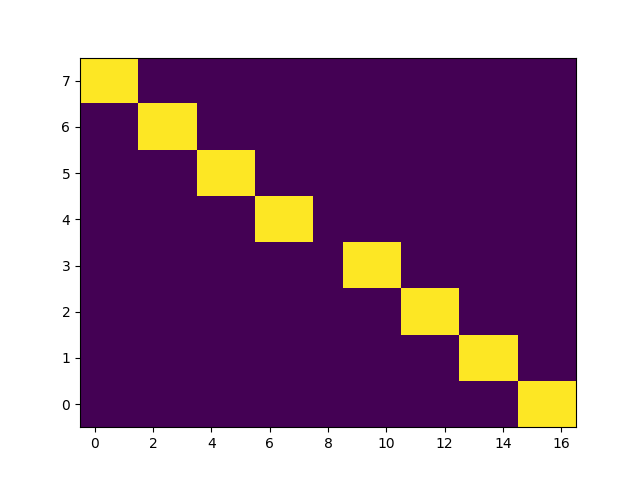

In [39]:
t = thefdmt.add_frb_track(16)
figure()
imshow(t, aspect='auto', origin='lower', interpolation='none')

In [40]:
def image2trace(image):
    '''
    See vivek's idea for an improvement
    '''
    nc = image.shape[0]
    trace = []
    last_start_idx = None
    last_end_idx = None
    for c in range(nc):
        x = image[c,:]
        kernel_idxs = np.where(x != 0)[0]
        startidx = kernel_idxs[0]
        endidx = kernel_idxs[-1]
        krnl = x[startidx:endidx+1]
        if c > 0:
            newoff = last_end_idx - endidx
            trace[-1][0] = newoff            
        else:
            newoff = None
            
        
        trace.append([0, krnl]) # fill offset = 0 to start with. it'll be overwritten next iteration
        #print(c, 'start=',startidx, 'end=',endidx, krnl, kernel_idxs, x, 'newoff', newoff)
        last_start_idx = startidx    
        last_end_idx = endidx
        
    return trace

        
image2trace(t)
#mask_to_trace(t[:,::-1])

[[2, array([1., 1.], dtype=float32)],
 [2, array([1., 1.], dtype=float32)],
 [2, array([1., 1.], dtype=float32)],
 [3, array([1., 1.], dtype=float32)],
 [2, array([1., 1.], dtype=float32)],
 [2, array([1., 1.], dtype=float32)],
 [2, array([1., 1.], dtype=float32)],
 [0, array([1., 1.], dtype=float32)]]

<IPython.core.display.Javascript object>


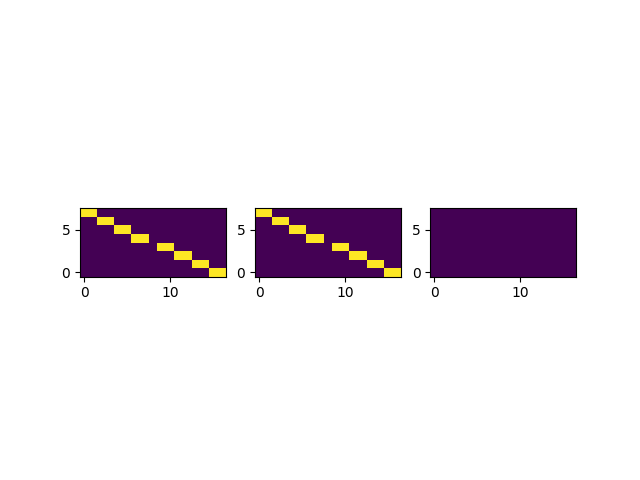

trace2image nc= 8 total_offset 15 largest_kernel 2 nt= 17
0 start= 15 end= 17 2 [1. 1.] curr 17
1 start= 13 end= 15 2 [1. 1.] curr 15
2 start= 11 end= 13 2 [1. 1.] curr 13
3 start= 9 end= 11 3 [1. 1.] curr 11
4 start= 6 end= 8 2 [1. 1.] curr 8
5 start= 4 end= 6 2 [1. 1.] curr 6
6 start= 2 end= 4 2 [1. 1.] curr 4
7 start= 0 end= 2 0 [1. 1.] curr 2


In [41]:
def trace2image(trace):
    '''
    Produces and image given a trace
    Trace is a list of (offset, kernel) tuples - length nchannels
    offset if positive for backwards in time.
    Offset for channel i is between channel i and channel i+1
    Kernel for channel 0 ends at the final time
    '''
    nc = len(trace)
    kernels = [t[1] for t in trace]
    offsets = [t[0] for t in trace]
    last_off = offsets[-1]
    total_offset = sum(offsets)
    kernel_lengths = map(len, kernels)
    largest_kernel = max(kernel_lengths)
    nt = largest_kernel + total_offset
    print('trace2image nc=', nc, 'total_offset', total_offset, 'largest_kernel', largest_kernel, 'nt=', nt)
    mask = np.zeros((nc,nt))
    curr_endidx = nt# cumulative offset - right hand side of kernel
    for ichan, (offset, kernel) in enumerate(trace):       
        endidx = curr_endidx
        startidx = endidx - len(kernel) 
        print(ichan, 'start=', startidx, 'end=', endidx, offset, kernel, 'curr', curr_endidx)
        mask[ichan, startidx:endidx] = kernel
        curr_endidx -= offset
        
   #assert coffset - len(kernel) == 0, f'Coffset should be 0 it was {coffset}'
        
        
    return mask

fig, ax = subplots(1,3)
t2 = trace2image(image2trace(t))
ax[0].imshow(t, origin='lower')
ax[1].imshow(t2, origin='lower')
ax[2].imshow(t2 - t, origin='lower')

In [42]:
d = EsamTree(nchan,0)
for idm in range(0, 64):
    t = thefdmt.add_frb_track(idm)
    d.get_trace_pid(image2trace(t))


In [43]:
print(len(d._products))

64


In [44]:
din = thefdmt.add_frb_track(8)
pad = np.zeros((nchan, 32))
din = np.hstack([pad, din, pad])
din.shape

(8, 73)

In [45]:
dout = d(din)

In [46]:
dout.shape

(64, 73)

<IPython.core.display.Javascript object>


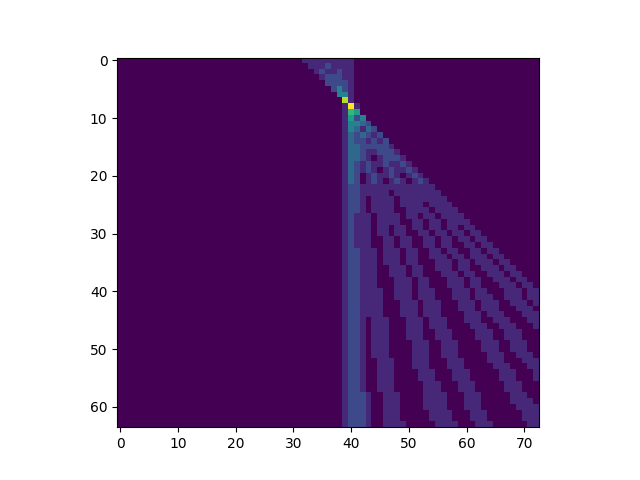

9.0 9.0


In [47]:
figure()
print(sum(din), dout.max())
imshow(dout)

<IPython.core.display.Javascript object>


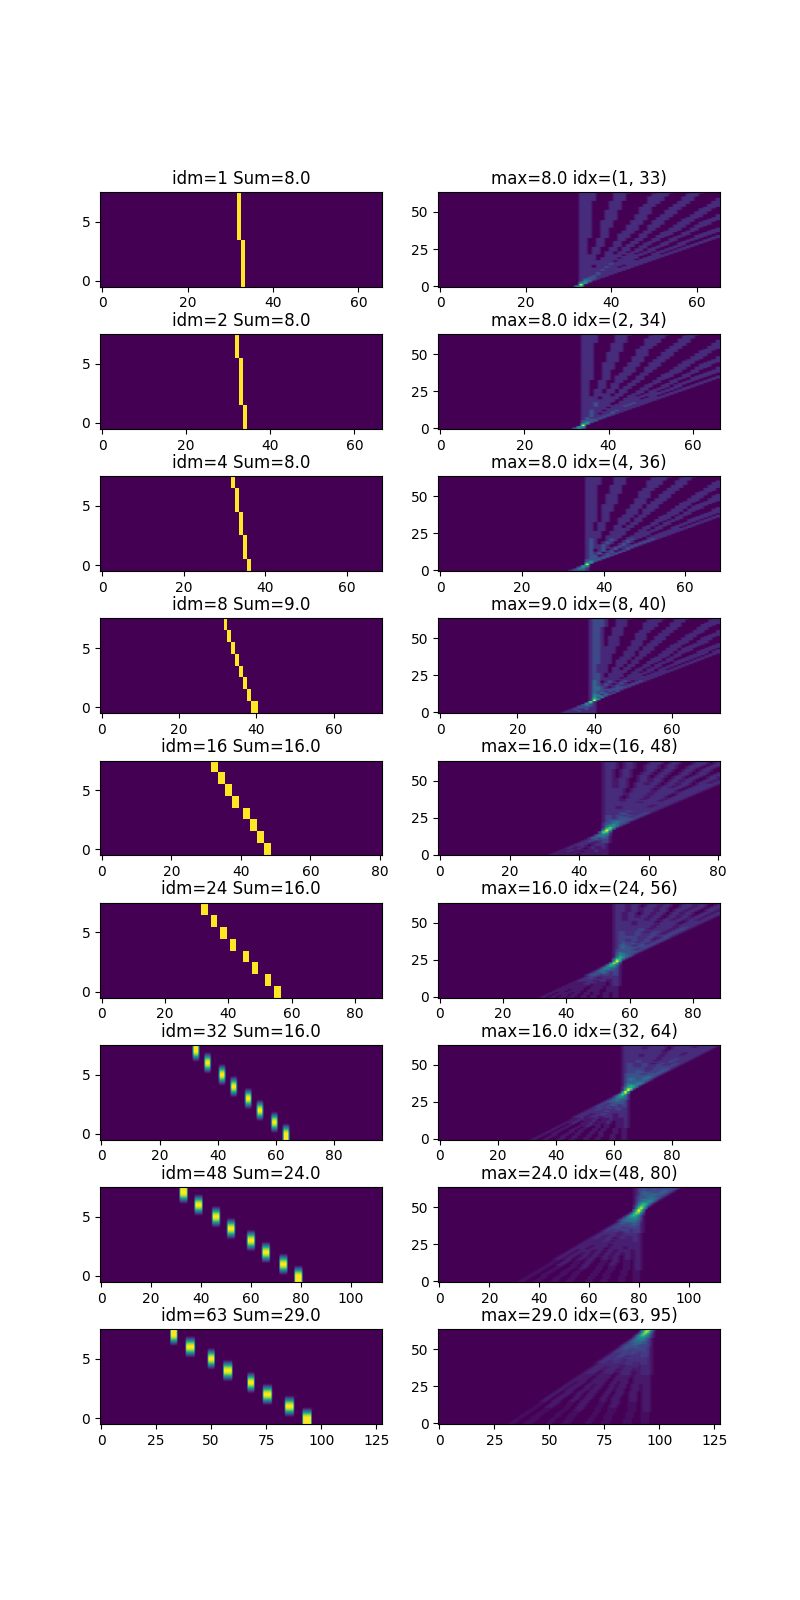

1 8.0 8.0
2 8.0 8.0
4 8.0 8.0
8 9.0 9.0
16 16.0 16.0
24 16.0 16.0
32 16.0 16.0
48 24.0 24.0
63 29.0 29.0


In [48]:
dms = [1,2,4,8,16,24, 32, 48, 63]
fig, ax = subplots(len(dms), 2)
plt.subplots_adjust(hspace=0.5)
fig.set_size_inches((8,16))


for iax, idm in enumerate(dms):
    din = thefdmt.add_frb_track(idm)
    pad = np.zeros((nchan, 32))
    din = np.hstack([pad, din, pad])
    dout = d(din)
    din.shape
    print(idm, sum(din), dout.max())
    ax[iax,0].imshow(din, aspect='auto', origin='lower')
    ax[iax,1].imshow(dout, aspect='auto', origin='lower')
    ax[iax,0].set_title(f'idm={idm} Sum={din.sum()}')
    idx = np.unravel_index(dout.argmax(), dout.shape)
    ax[iax,1].set_title(f'max={dout.max()} idx={idx}')


# OK, now play the whole game

In [49]:
nchan = 256
ndm = 1024
tree = EsamTree(nchan,0)
thefdmt = fdmt.Fdmt(850e6, 1e6, nchan, ndm, 256)
idms = np.arange(ndm)
pids = []
insums = []
nproducts = []
for idm in idms:
    t = thefdmt.add_frb_track(idm)
    pid = tree.get_trace_pid(image2trace(t))
    nproducts.append(tree.total_products)
    insums.append(t.sum())   
    pids.append(pid)
    

In [50]:
# Now verify it
maxvals = []
maxt = []
maxprod = []
for idm in idms:
    t = thefdmt.add_frb_track(idm)
    pad = np.zeros((nchan, 32))
    img = np.hstack([pad,t,pad])
    dout = tree(img, doprint=False)
    maxidx = dout.argmax()
    prodmax, tmax = np.unravel_index(maxidx, dout.shape)
    maxt.append(tmax)
    maxprod.append(prodmax)
    maxvals.append(dout.max())
    
insums = np.array(insums)
maxvals = np.array(maxvals)

<IPython.core.display.Javascript object>


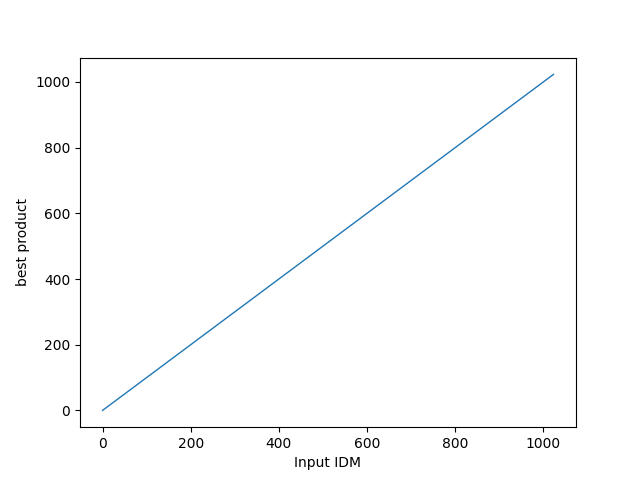

Text(0, 0.5, 'best product')

In [51]:
figure()
plot(idms, maxprod)
xlabel('Input IDM')
ylabel('best product')

<IPython.core.display.Javascript object>


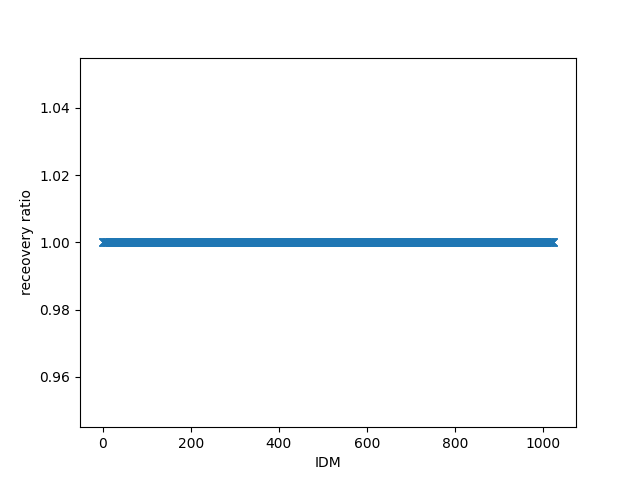

Text(0, 0.5, 'receovery ratio')

In [52]:
figure()
plot(idms, maxvals / insums, 'x')
xlabel('IDM')
ylabel('receovery ratio')

<IPython.core.display.Javascript object>


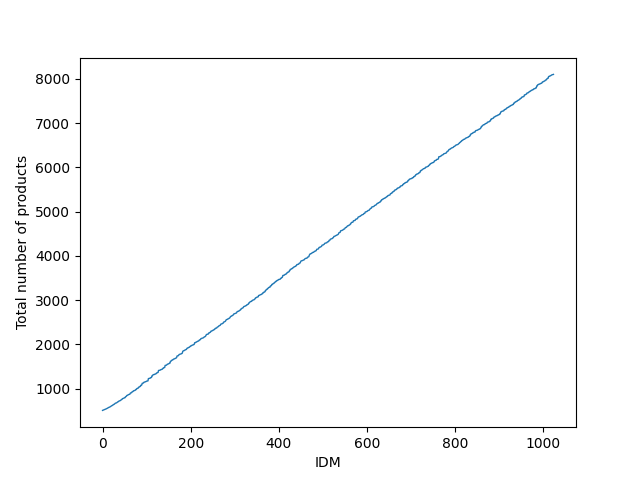

Text(0, 0.5, 'Total number of products')

In [53]:
figure()
plot(idms, nproducts)
xlabel('IDM')
ylabel('Total number of products')

<IPython.core.display.Javascript object>


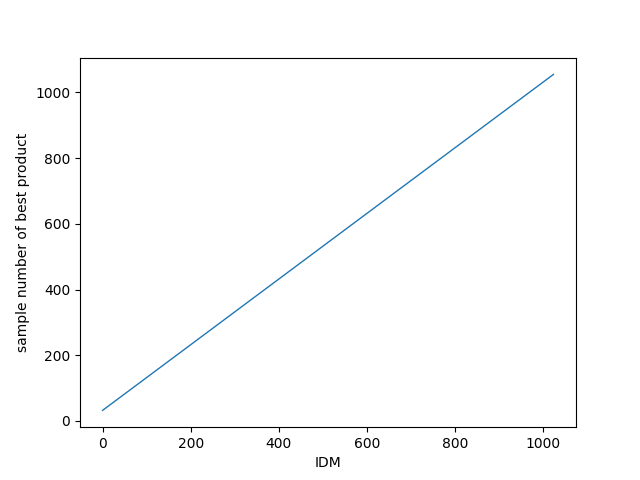

Text(0, 0.5, 'sample number of best product')

In [54]:
figure()
plot(idms, maxt)
xlabel('IDM')
ylabel('sample number of best product')